# Advanced Machine Learning: Progetto
## Parte 3 - Modello continuo per TripDuration
Progetto finale del corso di Advanced Machine Learning: predizione della durata di un viaggio in taxi a New York.
<br>Anno Accademico: 2018/2019
<br>Studenti:
- Mattia Pennati - 793375
- Mirko Rima - 793435
- Francesco Rovera - 794194

## 1) Import Librarie

In [0]:
# Generali
import numpy as np
import pandas as pd
import math
# Suddividere un dataset in train e test set
from sklearn.model_selection import train_test_split
# Statistiche descrittive per un dataset
from scipy import stats
# Plots
import matplotlib.pyplot as plt
# Google Drive
from google.colab import drive
# Machine Learning
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.layers.core import Dropout
from keras.utils import np_utils
from keras import backend as K
# Ottimizzazione Bayesiana
!pip install pyGPGO
from pyGPGO.covfunc import squaredExponential 
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition
from sklearn import preprocessing

## 2) Dati

Import del dataset finale da Google Drive, analisi di outliers, normalizzazione e  breve analisi delle features.

### 2.1) Import del Dataset
Connettere COLAB e Google Drive e importare i dataset

In [0]:
drive.mount('/content/drive')
train = np.genfromtxt('drive/My Drive/AML_TaxiTripDuration_Pennati_Rima_Rovera/Dataset/DatasetFinale.csv', delimiter=',', dtype='unicode')
train= train[1:,1:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2) Analisi delle features



Analizzare brevemente le features del dataset e calcolarne la correlazione

               hour  passenger_count  pickup_longitude  pickup_latitude  \
count  1.227280e+06     1.227280e+06      1.227280e+06     1.227280e+06   
mean   1.360704e+01     1.661490e+00     -7.397760e+01     4.075301e+01   
std    6.385631e+00     1.312861e+00      2.657017e-02     2.382145e-02   
min    0.000000e+00     0.000000e+00     -7.420209e+01     4.055138e+01   
25%    9.000000e+00     1.000000e+00     -7.399211e+01     4.073862e+01   
50%    1.400000e+01     1.000000e+00     -7.398210e+01     4.075475e+01   
75%    1.900000e+01     2.000000e+00     -7.396877e+01     4.076854e+01   
max    2.300000e+01     7.000000e+00     -7.367950e+01     4.092044e+01   

       dropoff_longitude  dropoff_latitude  trip_duration         tempm  \
count       1.227280e+06      1.227280e+06   1.227280e+06  1.227280e+06   
mean       -7.397561e+01      4.075300e+01   7.767751e+02  1.254005e+01   
std         2.681480e-02      2.966196e-02   5.385533e+02  9.350979e+00   
min        -7.420210e+01

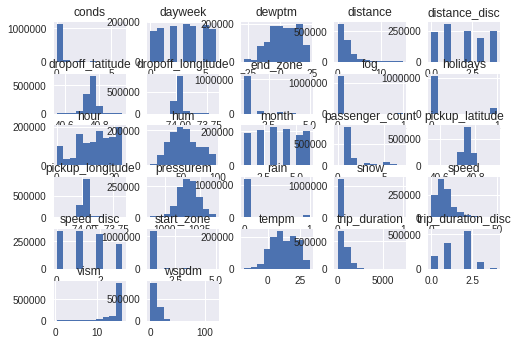

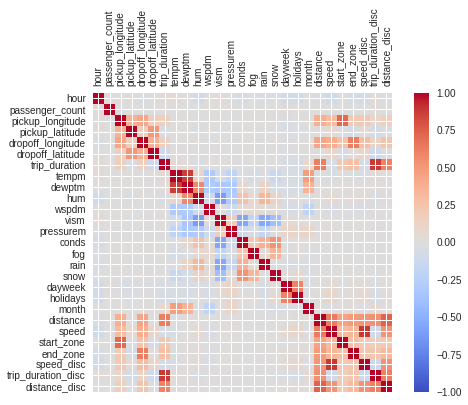

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


               hour  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  1.227280e+06      1.227280e+06     1.227280e+06       1.227280e+06   
mean   1.360704e+01     -7.397760e+01     4.075301e+01      -7.397561e+01   
std    6.385631e+00      2.657017e-02     2.382145e-02       2.681480e-02   
min    0.000000e+00     -7.420209e+01     4.055138e+01      -7.420210e+01   
25%    9.000000e+00     -7.399211e+01     4.073862e+01      -7.399141e+01   
50%    1.400000e+01     -7.398210e+01     4.075475e+01      -7.398020e+01   
75%    1.900000e+01     -7.396877e+01     4.076854e+01      -7.396458e+01   
max    2.300000e+01     -7.367950e+01     4.092044e+01      -7.367746e+01   

       dropoff_latitude  trip_duration         tempm           hum  \
count      1.227280e+06   1.227280e+06  1.227280e+06  1.227280e+06   
mean       4.075300e+01   7.767751e+02  1.254005e+01  5.472124e+01   
std        2.966196e-02   5.385533e+02  9.350979e+00  1.890831e+01   
min        4.055233e+01   

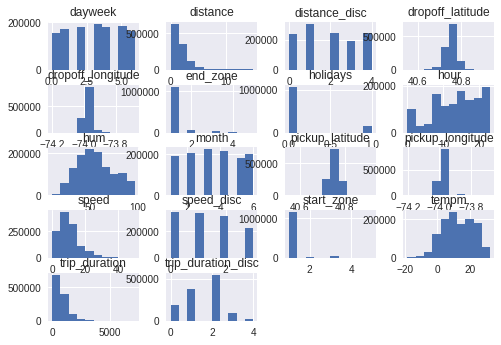

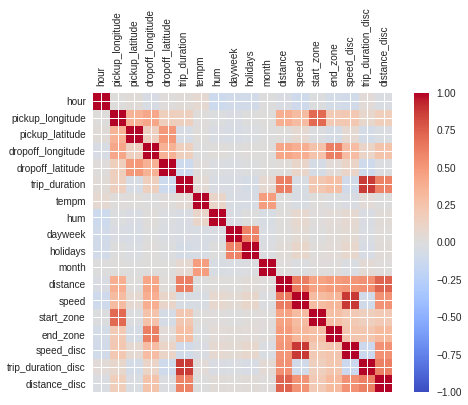

In [0]:
# Analizzare le features del dataset
data = train
columns = data[0,:]
data = data[1:,:].astype(float)
data = pd.DataFrame(data=data,columns=columns)
print(data.describe())

# Istogramma per ogni feature
data.hist()
plt.show()

# Correlazione
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

# Rimozione colonne incorrelate
toDelete =[] 
for i in range(0, len(corr['trip_duration'])): 
  if(np.abs(corr['trip_duration'][i]) < 0.025): 
    toDelete = np.append(toDelete, i) 
train = np.delete(train, toDelete, axis = 1)

# Analizzare nuovamente le features del dataset
data = train
columns = data[0,:]
data = data[1:,:].astype(float)
data = pd.DataFrame(data=data,columns=columns)
print(data.describe())

# Istogramma per ogni feature rimasta
data.hist()
plt.show()

# Correlazione sulle feature rimaste
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

### 2.2) Outliers e normalizzazione tramite Z-score

Trovare e rimuovere gli outliers sfruttando Z-score e normalizzare il dataset sempre tramite Z-score.

In [0]:
#REF: #https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

#Z-score
z = np.abs(stats.zscore(train[1:,:].astype(float)))
a = np.where(z > 3.5) #3.5 soglia
b = np.where(z < -3.5)
#(a[0]: righe, a[1]: colonne --> a[0][1] è un valore outlier)

print('Dimensione dataset prima della rimozione degli outliers tramite Z-score: ',train.shape)
train = np.delete(train, [a[0]], axis=0)
print('Dimensione dataset prima della rimozione degli outliers tramite Z-score: ',train.shape)

# Scalare i dati (ma non la variabile target)
train[1:,0:5] = preprocessing.scale(train[1:,0:5])
train[1:,7:] = preprocessing.scale(train[1:,7:])

Dimensione dataset prima della rimozione degli outliers tramite Z-score:  (1227281, 18)
Dimensione dataset prima della rimozione degli outliers tramite Z-score:  (1137115, 18)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U22 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U22 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## 3) Modello iniziale
Definire una semplice rete neurale che funga da regressore e addestrarla sul dataset di riferimento.

### 3.1) Definizione del modello
Scegliere la variabile target ( 6:"trip_duration"), suddividere il train set in train e validation e definire il modello di riferimento.
<br> Abbiamo precedentemente creato l'attributo speed in fase di analisi per un controllo dei dati, risultando poi poco utile e poichè avrebbe influenzato il nostro modello ELIMINIAMO le istanze di "speed".
<br> OSS: non si considerano più di due livelli di neuroni nascosti per il numero non elevato di features da analizzare.

In [0]:
# Variabile target
tlabels = train[1:,5]
train = np.delete(train, [5,12,15,16], axis=1) 

# Split del training set
train, validation, tlabels, vlabels = train_test_split(train[1:,:],
                                                       tlabels,
                                                       test_size = 0.25,
                                                       random_state=42)

# Creare semplice modello per prova
model = Sequential()
model.add(Dense(32, input_dim=train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear')) #linear come attivazione per target continui, 1 perchè il target è continuo

# Definire la metrica 'rmsle' (root mean square log error)
def rmsle(y_true, y_pred):
  y_pred = np.abs(y_pred + 1)
  y_true = np.abs(y_true + 1)
  return np.abs(K.sqrt(K.mean(K.square(K.log(y_pred)-K.log(y_true)),axis=-1)))

# Compilare il modello con i parametri necessari alla fase di training
# loss = mse (mean squared error) per target continui
model.compile(loss='mse', optimizer='rmsprop', metrics=[rmsle])

# Informazioni sul modello
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
None


### 3.2) Fase di training del modello e risultati

Addestrare la rete definita in precedenza e visualizzarne i risultati in termini di RMSLE (Root Mean Squared Logarithmic Error) sul validation set.

In [0]:
# Early stopping per la fase di training
early_stop = EarlyStopping(monitor='val_rmsle', patience=3, verbose=1) 

#model.fit parameters: training set, target variable, validation data, number of epochs, batch size
mse_h = model.fit(train, tlabels, validation_data=(validation,vlabels), epochs=20, batch_size=128, callbacks=[early_stop])

# Score (rmsl)
trainscore = mse_h.history['rmsle'][len(mse_h.history['rmsle'])-1]
valscore = mse_h.history['val_rmsle'][len(mse_h.history['val_rmsle'])-1]
print("RMSLE finale sul training set: ", np.round(trainscore,3))
print("RMSLE finale sul validation set: ", np.round(valscore,3))

Instructions for updating:
Use tf.cast instead.
Train on 852835 samples, validate on 284279 samples
Epoch 1/20
852835/852835 [==============================] - 42s 49us/step - loss: 218188.7808 - rmsle: 0.6321 - val_loss: 145356.0339 - val_rmsle: 0.4026
Epoch 2/20
852835/852835 [==============================] - 40s 47us/step - loss: 129163.0674 - rmsle: 0.3743 - val_loss: 124210.8541 - val_rmsle: 0.3600
Epoch 3/20
852835/852835 [==============================] - 40s 46us/step - loss: 115026.4215 - rmsle: 0.3416 - val_loss: 107301.2039 - val_rmsle: 0.3239
Epoch 4/20
852835/852835 [==============================] - 39s 46us/step - loss: 100835.3996 - rmsle: 0.3157 - val_loss: 99093.2082 - val_rmsle: 0.3125
Epoch 5/20
852835/852835 [==============================] - 39s 46us/step - loss: 96109.1066 - rmsle: 0.3067 - val_loss: 95752.0539 - val_rmsle: 0.3035
Epoch 6/20
852835/852835 [==============================] - 41s 48us/step - loss: 93584.6298 - rmsle: 0.3012 - val_loss: 93797.8307 -

## 4) Ottimizzazione
Utilizzare Grid Search e Ottimizzazione Bayesiana tramite Gaussian Process e Random Forest per ottenere i migliori iper-parametri per il modello

In [0]:
# Variabile target
tlabels = train[1:,5]
train = np.delete(train, [5,12,15,16], axis=1) 

# Split del training set
train, validation, tlabels, vlabels = train_test_split(train[1:,:],
                                                       tlabels,
                                                       test_size = 0.25,
                                                       random_state=42)

# Definire la metrica 'rmsle' (root mean square log error)
def rmsle(y_true, y_pred):
  y_pred = np.abs(y_pred + 1)
  y_true = np.abs(y_true + 1)
  return np.abs(K.sqrt(K.mean(K.square(K.log(y_pred)-K.log(y_true)),axis=-1)))

# Early stopping per la fase di training
early_stop = EarlyStopping(monitor='val_rmsle', patience=3, verbose=1)

### 4.1) Modello Baseline
Definire il modello baseline per l'ottimizzazione tramite funzioni che ritornino lo score dopo 5-fold cross validation
<br>OSS: si utilizzano solo le prime 100000 voci del dataset per limitare il costo computazionale

In [0]:
# Baseline: 5 fold cross validation su una NN 
def NNmodel(loss, opt, unitlevel1, unitlevel2, batch):
  # Ri-creazione del dataset
  dataset = (np.concatenate((train,validation)).astype(float))
  dataset = dataset[0:100000,:]
  label = (np.concatenate((tlabels,vlabels)).astype(float))
  label = label[0:100000]
  # Creazione delle 5 fold (dataset già "shuffled nella division in train/val")
  datasets = np.array_split(dataset, 5)
  labels = np.array_split(label, 5)
  # Vettore dei risultati
  cvscores = []
  tests = [0,1,2,3,4]
  # 5-fold cross validation
  for i in range(0,5):
    # Train e test
    ts = datasets[tests[i]]
    tsl = labels[tests[i]]
    trains = [0,1,2,3,4]
    trains.remove(tests[i])
    args = (datasets[trains[0]],datasets[trains[1]],datasets[trains[2]],
            datasets[trains[3]])
    tr = np.concatenate(args,axis=0)
    args = (labels[trains[0]],labels[trains[1]],labels[trains[2]],
            labels[trains[3]])
    trl = np.concatenate(args,axis=0)
    # Modello
    regressor = Sequential()
    unitlevel1 = int(unitlevel1)
    unitlevel2 = int(unitlevel2)
    batch = int(batch)
    regressor.add(Dense(unitlevel1, input_dim=tr.shape[1], activation='relu'))
    regressor.add(Dense(unitlevel2, activation='relu'))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(1, activation='linear'))
    regressor.compile(loss=loss, optimizer=opt, metrics=[rmsle])
    # Fit del modello
    h = regressor.fit(tr, trl, validation_data=(ts,tsl), epochs=10, batch_size=batch, verbose=0, callbacks=[early_stop])
    # Valutazione del modello
    score = h.history['val_rmsle'][len(h.history['val_rmsle'])-1]
    cvscores.append(score)
  print('RMSLE --> ', sum(cvscores)/len(cvscores),"\n")
  return (sum(cvscores)/len(cvscores))

def NNmodel2(lr, u1, u2):
  u1 = int(math.floor(u1))
  u2 = int(math.floor(u2))
  print('Config --> lr = ', lr, 'units level 1 = ', u1, 'units level 2 = ', u2)
  # Ri-creazione del dataset
  dataset = (np.concatenate((train,validation)).astype(float))
  dataset = dataset[0:100000,:]
  label = (np.concatenate((tlabels,vlabels)).astype(float))
  label = label[0:100000]
  # Creazione delle 5 fold (dataset già "shuffled nella division in train/val")
  datasets = np.array_split(dataset, 5)
  labels = np.array_split(label, 5)
  # Vettore dei risultati
  cvscores = []
  tests = [0,1,2,3,4]
  # 5-fold cross validation
  for i in range(0,5):
    # Train e test
    ts = datasets[tests[i]]
    tsl = labels[tests[i]]
    trains = [0,1,2,3,4]
    trains.remove(tests[i])
    args = (datasets[trains[0]],datasets[trains[1]],datasets[trains[2]],
            datasets[trains[3]])
    tr = np.concatenate(args,axis=0)
    args = (labels[trains[0]],labels[trains[1]],labels[trains[2]],
            labels[trains[3]])
    trl = np.concatenate(args,axis=0)
    # Modello
    regressor = Sequential()
    regressor.add(Dense(u1, input_dim=tr.shape[1], activation='relu'))
    regressor.add(Dense(u2, activation='relu'))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(1, activation='linear'))
    regressor.compile(loss='mae', optimizer=Adam(lr=lr), metrics=[rmsle])
    # Fit del modello
    h = regressor.fit(tr, trl, validation_data=(ts,tsl), epochs=10, batch_size=128, verbose=0, callbacks=[early_stop])
    # Valutazione del modello
    score = h.history['val_rmsle'][len(h.history['val_rmsle'])-1]
    cvscores.append(score)
  print('RMSLE --> ', sum(cvscores)/len(cvscores),"\n")
  return -(sum(cvscores)/len(cvscores)) # meno per massimizzare comunque (massimizzare -rmsle)

### 4.2) Grid Search
Semplice Grid Search per i prinicipali iper-parametri.

Configuration  0  --> unitlevel1 =  16  unitlevel2 =  8  batchsize =  128  loss =  mae  opt =  rmsprop
RMSLE -->  0.4056283373641968 

Configuration  1  --> unitlevel1 =  16  unitlevel2 =  32  batchsize =  128  loss =  mae  opt =  rmsprop
RMSLE -->  0.38599699604034426 

Configuration  2  --> unitlevel1 =  64  unitlevel2 =  8  batchsize =  128  loss =  mae  opt =  rmsprop
RMSLE -->  0.38730115127563475 

Configuration  3  --> unitlevel1 =  64  unitlevel2 =  32  batchsize =  128  loss =  mae  opt =  rmsprop
RMSLE -->  0.3453553664588928 

Configuration  4  --> unitlevel1 =  16  unitlevel2 =  8  batchsize =  128  loss =  mae  opt =  adam
RMSLE -->  0.4027387942123413 

Configuration  5  --> unitlevel1 =  16  unitlevel2 =  32  batchsize =  128  loss =  mae  opt =  adam
RMSLE -->  0.38596818437576297 

Configuration  6  --> unitlevel1 =  64  unitlevel2 =  8  batchsize =  128  loss =  mae  opt =  adam
RMSLE -->  0.388503662929535 

Configuration  7  --> unitlevel1 =  64  unitlevel2 =  32  b

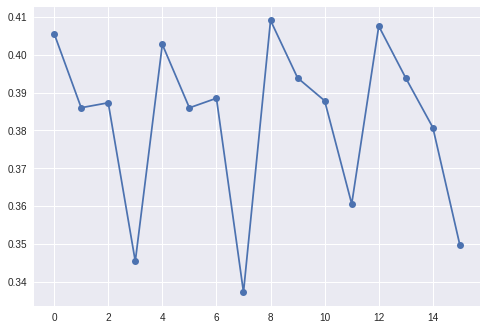

In [0]:
# Definire il range dei parametri
lossrange = ['mae', 'mse']
optrange = ['rmsprop', 'adam']
unitlevel1range = [16,64] #solo 2 valori fra loro distanti per ri-ottimizzarli poi campionando intorno al miglior valore
unitlevel2range = [8,32]
batchsizerange = [128]#, 256] #provato con 256 peggiora di circa il 3% senza un risparmio di tempo notevole

rng = len(lossrange)*len(optrange)*len(unitlevel1range)*len(unitlevel2range)*len(batchsizerange)
res = [0 for n in range(rng)]
count = 0
best = 5
bestparameters = ['','',0,0,0]
for l in lossrange:
    for o in optrange:
      for u1 in unitlevel1range:
        for u2 in unitlevel2range:
          for b in batchsizerange:
            print('Configuration ',count ,' --> unitlevel1 = ',u1 ,' unitlevel2 = ',u2,' batchsize = ', b, ' loss = ', l, ' opt = ', o)
            res[count] = NNmodel(l,o,u1,u2,b)
            if(res[count]<best):
              best = res[count]
              bestparameters = [l,o,u1,u2,b]
            count = count+1

plt.plot(res, marker="o")

print("Best rmsle on the grid:"+str(np.round(min(np.asarray(res)),3)))
print("Best parameters: Loss function=", bestparameters[0], 
      ", Optimization function =", bestparameters[1],
      ", Hidden level 1 units= ", bestparameters[2],
      ", Hidden level 2 units= ", bestparameters[3],
      ", Batch size= ",bestparameters[4])

### 4.3) Ottimizzazione Bayesiana
Dopo aver fissato i maggiori parametri tramite grid search eseguire ottimizzazione bayesiana per esplorare i parametri dell'ottimizzatore scelto.
<br>OSS: modificare NNmodel2 definita in precedenza inserendo i migliori parametri ottenuti tramite Grid Search

Definire i parametri da ottimizzare, un dizionario e una combinatoria di casi

In [0]:
# Dizionario per gli iper-parametri
param = {'lr': ('cont', [0.0005,0.01]), 'u1': ('cont', [50, 78]), 'u2': ('cont', [20, 44])}

# Range degli iper-parametri
lrRange = list(param.values())[0][1]
u1Range = list(param.values())[1][1]
u2Range = list(param.values())[2][1]

# Combinatoria dei parametri
xs = np.linspace(lrRange[0],lrRange[1],10).reshape((10,1))
ys = np.linspace(u1Range[0],u1Range[1],10).reshape((10,1))
zs = np.linspace(u2Range[0],u2Range[1],10).reshape((10,1))
xx,yy, zz = np.meshgrid(xs,ys, zs)
pp = [[0 for j in range(3)] for i in range(len(xs)*len(ys)*len(zs))]
for i in range(len(xs)):
    for j in range(len(ys)):
      for k in range(len(zs)):
        pp[(i*len(ys))+len(zs)*j+k][2] = zs[k]
        pp[(i*len(ys))+len(zs)*j+k][0] = xs[i]
        pp[(i*len(ys))+len(zs)*j+k][1] = ys[j]
pp = np.asarray(pp).reshape(len(xs)*len(ys)*len(zs),3)

#### 4.3.1) Gaussian Process
Eseguire Ottimizzazione Bayesiana tramite Gaussian Process

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Config --> lr =  0.009317122431964532 units level 1 =  72 units level 2 =  30
RMSLE -->  0.2793399125909805 

Config --> lr =  0.0008372711234081159 units level 1 =  57 units level 2 =  23
RMSLE -->  0.36611557726860045 

Config --> lr =  0.009633029094243316 units level 1 =  52 units level 2 =  38
RMSLE -->  0.2812706668615341 

Config --> lr =  0.0033764174369889555 units level 1 =  64 units level 2 =  42
RMSLE -->  0.29624507417678836 

Config --> lr =  0.002854443974126147 units level 1 =  61 units level 2 =  25
RMSLE -->  0.30367935856342315 

Config --> lr =  0.0006063041818537594 units level 1 =  73 units level 2 =  31
RMSLE -->  0.38268065064430234 

Config --> lr =  0.0049631159335494935 units level 1 =  65 units level 2 =  25
RMSLE -->  0.29394850880146023 

Config --> lr =  0.002775112129540395 units level 1 =  52 units level 2 =  27
RMSLE -->  0.30545255879878996 

Config --> lr =  0.0008585272002006257 units level 1

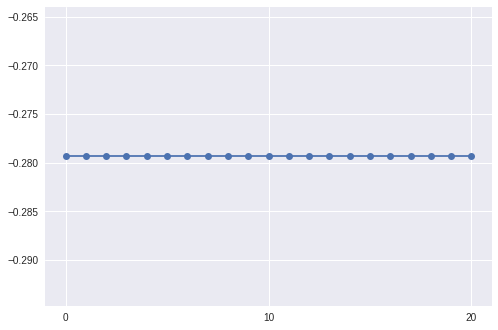

In [0]:
# Funzione di Covarianza per il Gaussian Process
sqrexp = squaredExponential()

# Definizione del Gaussian process
gp = GaussianProcess(covfunc=sqrexp)

# Scelta della funzione di acquisizione
acq = Acquisition(mode="ExpectedImprovement")

# Creazione dell'ottimizzatore bayesiano
#GPGO(surrogate model, acquisition function, 
# function to be optimized (the model),  parameters to optimize the model, 
# number of threads)
bayesian_opt = GPGO(gp, acq, NNmodel2, param, n_jobs=1)

# Valutazione iniziale
initialpoints = 10 #numero di punti iniziali da usare  
bayesian_opt._firstRun(n_eval = initialpoints)

# Predizione, ottimizzazione della funzione di acquisizione e aggiornamento
# dell'oggetto ottimizzatore bayesiano
furtherEvaluations = 20
for iter in range(furtherEvaluations):
    # Predizioni
    predictions = bayesian_opt.GP.predict(pp,return_std=True)
    # Ottimizzazione della funzione di acquisizione tramite approccio multistart
    bayesian_opt._optimizeAcq(method='L-BFGS-B', n_start=100)
    # Aggiornamento dell'ottimizzatore
    bayesian_opt.updateGP()

# Miglior configurazione di parametri
print("Best parameters (acq(): Expected Improvement): \n")
print("Learning Rate=", bayesian_opt.best[0], "Unit1=", math.floor(bayesian_opt.best[1]), "Unit2=", math.floor(bayesian_opt.best[2]))
print("RMLSE: ", np.abs(np.round(np.max(bayesian_opt.history), 3)), "\n")
print("-----------------------------------------------------------------------")

# bayesian_opt plot
plt.xticks(np.arange(0, 30, step=10))
print("Ottimizzazione bayesiana: Gaussian Process")
plt.plot(bayesian_opt.history, marker="o")
plt.show()

## 6) Modello finale
Implementazione del modello finale con i migliori iper-parametri ottenuti dopo l'ottimizzazione, fase di training sull'intero dataset e visualizzazione dei risultati.
<br>OSS: è stato provato pure lasciando il learning rate al suo valore di default, ma, come prevedibile dopo l'ottimizzazione, i risultati sono leggermente peggiori (circa 0.02 in più di RMSLE sia per il train che per il validation)

Train on 852835 samples, validate on 284279 samples
Epoch 1/30
852835/852835 [==============================] - 84s 99us/step - loss: 239.3122 - rmsle: 0.3576 - val_loss: 196.2708 - val_rmsle: 0.2827
Epoch 2/30
852835/852835 [==============================] - 67s 79us/step - loss: 212.4136 - rmsle: 0.3078 - val_loss: 187.1489 - val_rmsle: 0.2717
Epoch 3/30
852835/852835 [==============================] - 67s 79us/step - loss: 206.9099 - rmsle: 0.2995 - val_loss: 185.1018 - val_rmsle: 0.2674
Epoch 4/30
852835/852835 [==============================] - 68s 79us/step - loss: 203.5850 - rmsle: 0.2942 - val_loss: 183.7310 - val_rmsle: 0.2667
Epoch 5/30
852835/852835 [==============================] - 68s 79us/step - loss: 200.6966 - rmsle: 0.2893 - val_loss: 183.8191 - val_rmsle: 0.2666
Epoch 6/30
852835/852835 [==============================] - 68s 79us/step - loss: 198.5819 - rmsle: 0.2860 - val_loss: 181.1678 - val_rmsle: 0.2635
Epoch 7/30
852835/852835 [==============================] - 

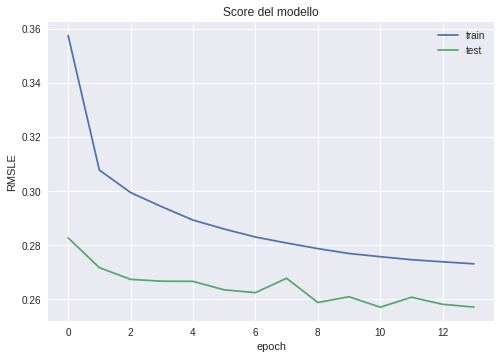

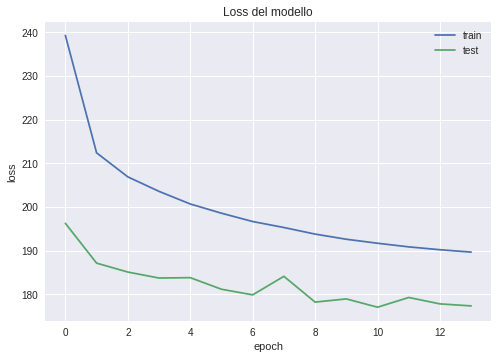

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_532 (Dense)            (None, 54)                810       
_________________________________________________________________
dense_533 (Dense)            (None, 20)                1100      
_________________________________________________________________
dropout_178 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_534 (Dense)            (None, 1)                 21        
Total params: 1,931
Trainable params: 1,931
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Modello
finalmodel = Sequential()
finalmodel.add(Dense(54, input_dim=train.shape[1], activation='relu'))
finalmodel.add(Dense(20, activation='relu'))
finalmodel.add(Dropout(0.2))
finalmodel.add(Dense(1, activation='linear'))

# Compilazione 
finalmodel.compile(loss='mae', optimizer=Adam(lr=0.01), metrics=[rmsle])
# Training del modello
h = finalmodel.fit(train, tlabels, validation_data=(validation,vlabels), epochs=30, batch_size=128, callbacks=[early_stop])

# Visualizzazione dei risultati 
trainscore = h.history['rmsle'][len(h.history['rmsle'])-1]
valscore = h.history['val_rmsle'][len(h.history['val_rmsle'])-1]
print("RMSLE finale sul training set: ", np.round(trainscore,3))
print("RMSLE finale sul validation set: ", np.round(valscore,3))

# Plot per RMSLE
plt.plot(h.history['rmsle'])
plt.plot(h.history['val_rmsle'])
plt.title('Score del modello')
plt.ylabel('RMSLE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Plot per la loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Loss del modello')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Struttura del modello
print(finalmodel.summary())